In [1]:
import sys
import os
sys.path.append('../')
from tqdm.auto import tqdm
from collections import defaultdict
from functools import partial
import py3Dmol
from IPython.display import IFrame, SVG, display, HTML
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from webapp.utils import (
    EasIFAInferenceAPI,
    UniProtParserMysql,
    retrain_ec_site_model_state_path,
    get_structure_html_and_active_data,
    cmd,
)


/home/xiaoruiwang/software/miniconda3/envs/py38/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
ECSitePred = EasIFAInferenceAPI(model_checkpoint_path=retrain_ec_site_model_state_path)
unprot_mysql_parser = UniProtParserMysql(
    mysql_config_path="../../webapp/mysql_config.json"
)

/home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/EasIFA_v2/script/../model_structure/esm_layer.py:297: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


Reaction attention model from scratch...
Loaded checkpoint from /home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/EasIFA_v2/checkpoints/enzyme_site_type_predition_model/train_in_uniprot_ecreact_cluster_split_merge_dataset_limit_100_at_2024-05-26-02-48-38/global_step_86000
[Errno 2] No such file or directory: '../../webapp/mysql_config.json'


In [3]:


def inference_and_show(rxn, enzyme_structure_path):
    pred_active_labels = ECSitePred.inference(rxn, enzyme_structure_path)

    structure_html, active_data = get_structure_html_and_active_data(
        enzyme_structure_path=enzyme_structure_path,
        site_labels=pred_active_labels,
        view_size=(600, 600),
    )
    display(HTML(structure_html))
    
    active_data_df = pd.DataFrame(active_data, columns=['Residue Index', 'Residue Name', 'Color', 'Active  Site Type'])
    display(active_data_df)

def draw_chemical_reaction(smiles, highlightByReactant=False, font_scale=1.5):
    rxn = rdChemReactions.ReactionFromSmarts(smiles,useSmiles=True)
    trxn = rdChemReactions.ChemicalReaction(rxn)
    d2d = rdMolDraw2D.MolDraw2DSVG(800,300)
    d2d.drawOptions().annotationFontScale=font_scale
    d2d.DrawReaction(trxn,highlightByReactant=highlightByReactant)

    d2d.FinishDrawing()

    return d2d.GetDrawingText()


In [4]:
test_dataset = pd.read_csv('../dataset/ec_site_dataset/uniprot_ecreact_cluster_split_merge_dataset_limit_100/test_dataset/uniprot_ecreact_merge.csv')

In [5]:
def get_rxn_str_from_ecreaction(ecreaction):
    substrates, products = ecreaction.split('>>')
    reactants, _ = substrates.split('|')
    return f'{reactants}>>{products}'

In [6]:
test_dataset['rxn_smiles'] = test_dataset['reaction'].apply(lambda x:get_rxn_str_from_ecreaction(x))
test_dataset['alphafolddb-id']= test_dataset['alphafolddb-id'].apply(lambda x:x.split(';')[0])
test_dataset

,reaction,ec,pdb-id,alphafolddb-id,aa_sequence,site_labels,site_types,rxn_smiles
0,Cc1c([N+](=O)[O-])cc([N+](=O)[O-])cc1[N+](=O)[...,1.-.-.-,4JJ0;4JJ3;,A0A1S7LCW6,MKLKGTTIVALGMLVVAIMVLASMIDLPGSDMSATPAPPDTPRGAP...,"[[206], [212], [215], [216], [246], [252], [25...","[0, 0, 0, 0, 0, 0, 0, 0]",Cc1c([N+](=O)[O-])cc([N+](=O)[O-])cc1[N+](=O)[...
1,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)([O-])OP(=O)(...,1.-.-.-,1E5D;,Q9F0J6,MQATKIIDGFHLVGAIDWNSRDFHGYTLSPMGTTYNAYLVEDEKTT...,"[[79], [81], [83], [146], [165], [165], [226]]","[0, 0, 0, 0, 0, 0, 0]",NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)([O-])OP(=O)(...
2,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)([O-])OP(=O)(...,1.-.-.-,7LO1;,Q5BEJ7,MADHEQEQEPLSIAIIGGGIIGLMTALGLLHRNIGKVTIYERASAW...,"[[41, 42], [245, 247], [320], [330, 334]]","[0, 0, 0, 0]",NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)([O-])OP(=O)(...
3,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)([O-])OP(...,1.-.-.-,5EZ7;,Q9HUH4,MPQALSTDILIVGGGIAGLWLNARLRRAGYATVLVESASLGGGQSV...,"[[17], [36], [44, 45], [49, 51], [346, 347]]","[0, 0, 0, 0, 0]",NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)([O-])OP(...
4,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)([O-])OP(...,1.-.-.-,3BEM;,P96692,MAEFTHLVNERRSASNFLSGHPITKEDLNEMFELVALAPSAFNLQH...,"[[11, 13], [68, 70], [157, 158], [193], [196]]","[0, 0, 0, 0, 0]",NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)([O-])OP(...
...,...,...,...,...,...,...,...,...
889,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,7.3.2.6,2ONK;,O30144,MFLKVRAEKRLGNFRLNVDFEMGRDYCVLLGPTGAGKSVFLELIAG...,"[[31, 38]]",[0],Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...
890,N[C@@H](CSC[C@H](N)C(=O)O)C(=O)O.Nc1ncnc2c1ncn...,7.4.2.-,5W0T;,P28737,MSRKFDLKTITDLSVLVGTGISLYYLVSRLLNDVESGPLSGKSRES...,"[[133, 140]]",[0],N[C@@H](CSC[C@H](N)C(=O)O)C(=O)O.Nc1ncnc2c1ncn...
891,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...,7.4.2.8,1P9R;1P9W;2BH1;4KSR;4KSS;,P37093,MTEMVISPAERQSIRRLPFSFANRFKLVLDWNEDFSQASIYYLAPL...,"[[397], [400], [430], [433]]","[0, 0, 0, 0]",Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...
892,CCCCCCCCCCCCCCCCCCCCCCCCC(C(=O)OC[C@H]1O[C@H](...,7.5.2.-,6YIR;,P94360,MAELRMEHIYKFYDQKEPAVDDFNLHIADKEFIVFVGPSGCGKSTT...,"[[37, 44]]",[0],CCCCCCCCCCCCCCCCCCCCCCCCC(C(=O)OC[C@H]1O[C@H](...


In [7]:
def show_one(index):
    # rxn = test_dataset['rxn_smiles'].tolist()[index]
    pdb_id = test_dataset['alphafolddb-id'].tolist()[index]
    try:
        query_data, _, _ = unprot_mysql_parser.query_from_uniprot(pdb_id)
        _, query_results_df, _, _ = query_data
        rxn = query_results_df["rxn_smiles"].tolist()[0]
    except:
        rxn = test_dataset['rxn_smiles'].tolist()[index]


    gt_site_labels = test_dataset['site_labels'].tolist()[index]
    ec_number = test_dataset['ec'].tolist()[index]
    print('EC Number:')
    print(ec_number)
    print('Reaction:')
    print(rxn)
    print('PDB Name:')
    print(pdb_id)
    print(f'https://www.uniprot.org/uniprotkb/{pdb_id}/entry')
    print('GT Site Lables:')
    print(gt_site_labels)

    display(SVG(draw_chemical_reaction(rxn)))
    enzyme_structure_path = os.path.abspath(f'../dataset/ec_site_dataset/structures/alphafolddb_download/AF-{pdb_id}-F1-model_v4.pdb')
    inference_and_show(rxn=rxn, enzyme_structure_path=enzyme_structure_path)
    display(IFrame(f'https://www.uniprot.org/uniprotkb/{pdb_id}/entry', width=1200, height=900))

def show_out_one(rxn, pdb_id):
    print('Reaction:')
    print(rxn)
    print('PDB Name:')
    print(pdb_id)
    display(SVG(draw_chemical_reaction(rxn)))
    if not os.path.exists(os.path.abspath(f'../dataset/ec_site_dataset/structures/alphafolddb_download/AF-{pdb_id}-F1-model_v4.pdb')):
        os.makedirs('./pdb_cache', exist_ok=True)
        os.system(f'wget https://alphafold.ebi.ac.uk/files/AF-{pdb_id}-F1-model_v4.pdb -O ./pdb_cache/AF-{pdb_id}-F1-model_v4.pdb' )
        enzyme_structure_path = os.path.abspath(f'./pdb_cache/AF-{pdb_id}-F1-model_v4.pdb')
    else:
        enzyme_structure_path = os.path.abspath(f'../dataset/ec_site_dataset/structures/alphafolddb_download/AF-{pdb_id}-F1-model_v4.pdb')
    
    inference_and_show(rxn=rxn, enzyme_structure_path=enzyme_structure_path)
    display(IFrame(f'https://www.uniprot.org/uniprotkb/{pdb_id}/entry', width=1200, height=900))

[Errno 2] No such file or directory: '../../webapp/mysql_config.json'
EC Number:
1.14.11.-
Reaction:
O=C([O-])CCC(=O)C(=O)[O-].O=O.[NH3+]CCCC[C@H]([NH3+])C(=O)[O-]>>O=C([O-])CCC(=O)[O-].O=C=O.[NH3+]CC[C@@H](O)C[C@H]([NH3+])C(=O)[O-]
PDB Name:
J3BZS6
https://www.uniprot.org/uniprotkb/J3BZS6/entry
GT Site Lables:
[[176], [178], [312]]


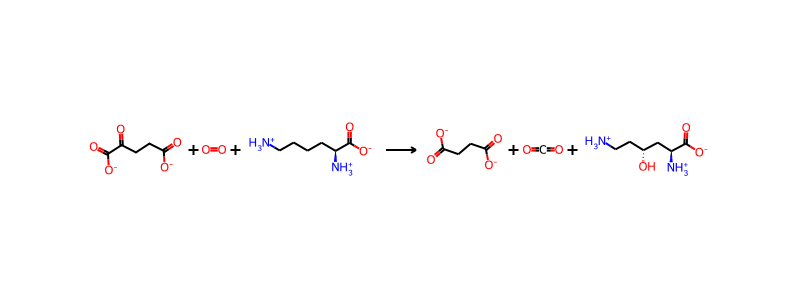

,Residue Index,Residue Name,Color,Catalyst Active Type
0,176,HIS,#FF0000,Binding Site
1,178,GLU,#FF0000,Binding Site
2,312,HIS,#FF0000,Binding Site


In [8]:
index= 110
show_one(index)

[Errno 2] No such file or directory: '../../webapp/mysql_config.json'
EC Number:
2.1.1.22
Reaction:
C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.[NH3+]CCC(=O)N[C@@H](Cc1c[nH]cn1)C(=O)[O-]>>Cn1cncc1C[C@H](NC(=O)CC[NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[C@@H]1O[C@H](CSCC[C@H]([NH3+])C(=O)[O-])[C@@H](O)[C@H]1O.[H+]
PDB Name:
P53934
https://www.uniprot.org/uniprotkb/P53934/entry
GT Site Lables:
[[108], [111], [146], [167], [235], [278], [286], [309], [385]]


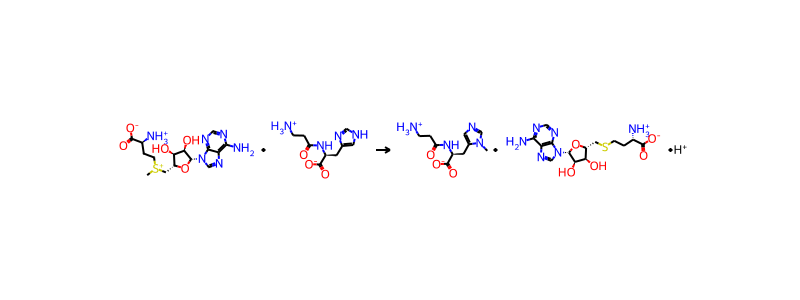

,Residue Index,Residue Name,Color,Catalyst Active Type
0,108,GLN,#FF0000,Binding Site
1,111,ARG,#FF0000,Binding Site
2,146,GLY,#FF0000,Binding Site
3,167,GLU,#FF0000,Binding Site
4,234,SER,#FF0000,Binding Site
5,235,PHE,#FF0000,Binding Site
6,274,ASN,#FF0000,Binding Site
7,278,ASP,#FF0000,Binding Site
8,286,TYR,#FF0000,Binding Site
9,309,HIS,#FF0000,Binding Site


In [9]:
index= 234
show_one(index)

[Errno 2] No such file or directory: '../../webapp/mysql_config.json'
EC Number:
3.1.-.-
Reaction:
Nc1nc2c(ncn2[C@@H]2O[C@@H]3COP(=O)([O-])O[C@@H]4[C@@H](COP(=O)([O-])O[C@@H]2[C@@H]3O)O[C@@H](n2cnc3c(N)ncnc32)[C@@H]4O)c(=O)[nH]1.O>>Nc1nc2c(ncn2[C@@H]2O[C@H](CO)[C@@H](O)[C@H]2OP(=O)([O-])OC[C@H]2O[C@@H](n3cnc4c(N)ncnc43)[C@H](O)[C@@H]2OP(=O)([O-])[O-])c(=O)[nH]1
PDB Name:
O06662
https://www.uniprot.org/uniprotkb/O06662/entry
GT Site Lables:
[[7], [98]]


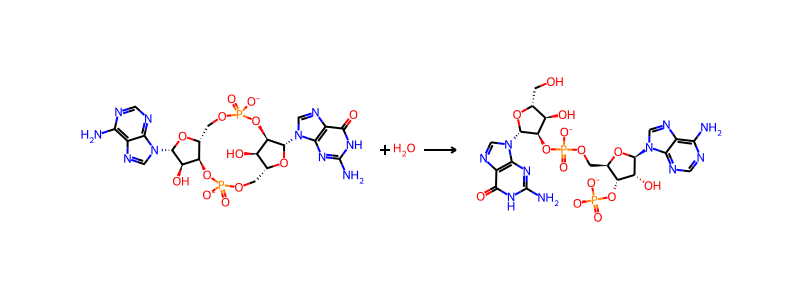

,Residue Index,Residue Name,Color,Catalyst Active Type
0,7,ASP,#FF0000,Binding Site
1,8,THR,#FF0000,Binding Site
2,98,ASP,#FF0000,Binding Site


In [10]:
index= 456
show_one(index)

[Errno 2] No such file or directory: '../../webapp/mysql_config.json'
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  1615    0  1615    0     0   1145      0 --:--:--  0:00:01 --:--:--  1144

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 24353    0 24353    0     0  30065      0 --:--:-- --:--:-- --:--:-- 30028
100  177k    0  177k    0     0   108k      0 --:--:--  0:00:01 --:--:--  108k

  % Total    % Received % Xferd  Average Speed   Time    

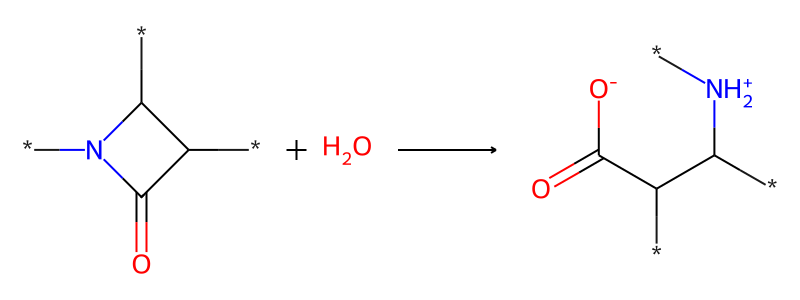

,Residue Index,Residue Name,Color,Catalyst Active Type
0,75,SER,#00B050,Catalytic Site
1,173,GLU,#00B050,Catalytic Site
2,237,LYS,#FF0000,Binding Site
3,238,THR,#FF0000,Binding Site
4,239,GLY,#FF0000,Binding Site


In [11]:
index= 654
show_one(index)

[Errno 2] No such file or directory: '../../webapp/mysql_config.json'
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2387    0  2387    0     0   1841      0 --:--:--  0:00:01 --:--:--  1841

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 18900    0 18900    0     0  33157      0 --:--:-- --:--:-- --:--:-- 33099
100  106k    0  106k    0     0  75554      0 --:--:--  0:00:01 --:--:-- 75554

EC Number:
3.1.3.48
Reaction:
*N[C@@H](Cc1ccc(OP(=O)([O-])[O-])cc1)C(*)=O.O>>*N[C@@H](Cc1ccc(O)cc1)C(*)=O.O=P([O-])([O-])O
PDB Name:
Q4G

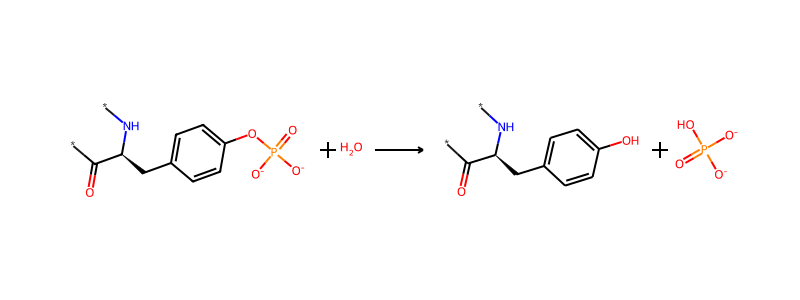

,Residue Index,Residue Name,Color,Catalyst Active Type
0,103,CYS,#00B050,Catalytic Site


In [12]:
index= 520
show_one(index)

In [13]:
index = 566
rxn = test_dataset['rxn_smiles'].tolist()[index]
pdb_id = test_dataset['alphafolddb-id'].tolist()[index]
print(rxn)
print(pdb_id)

O.OCC1OC(OC2C(O)C(CO)OC(OC3C(O)C(O)OC(CO)C3O)C2O)C(O)C(O)C1O>>O=C[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
P26222


In [14]:
index = 332
rxn = test_dataset['rxn_smiles'].tolist()[index]
pdb_id = test_dataset['alphafolddb-id'].tolist()[index]
print(rxn)
print(pdb_id)

C=C(C)CCOP(=O)([O-])OP(=O)([O-])[O-].CC(C)=CCC/C(C)=C/CC/C(C)=C/COP(=O)([O-])OP(=O)([O-])[O-]>>CC(C)=CCC/C(C)=C\CC/C(C)=C\CC/C(C)=C/COP(=O)(O)OP(=O)(O)O
P34802


Reaction:
CCCCC.CC>>CCCC
PDB Name:
P11586


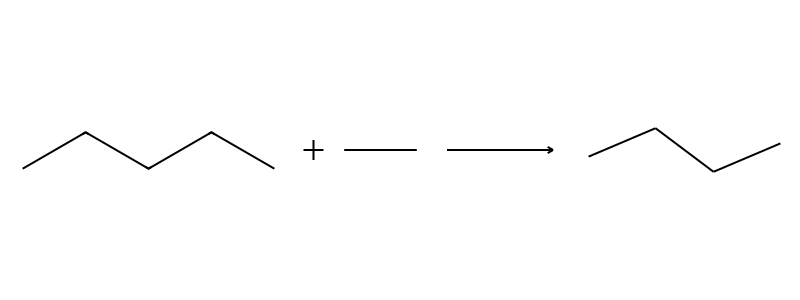

--2024-05-28 16:42:14--  https://alphafold.ebi.ac.uk/files/AF-P11586-F1-model_v4.pdb
Resolving alphafold.ebi.ac.uk (alphafold.ebi.ac.uk)... 34.149.152.8
Connecting to alphafold.ebi.ac.uk (alphafold.ebi.ac.uk)|34.149.152.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘./pdb_cache/AF-P11586-F1-model_v4.pdb’

     0K .......... .......... .......... .......... .......... 72.9K
    50K .......... .......... .......... .......... ..........  154K
   100K .......... .......... .......... .......... ..........  290K
   150K .......... .......... .......... .......... ..........  398K
   200K .......... .......... .......... .......... ..........  545K
   250K .......... .......... .......... .......... ..........  623K
   300K .......... .......... .......... .......... ..........  893K
   350K .......... .......... .......... .......... ..........  919K
   400K .......... .......... .......... .......... .........

,Residue Index,Residue Name,Color,Catalyst Active Type


In [15]:
show_out_one('CCCCC.CC>>CCCC', 'P11586')    # 瞎凑一个反应看看能不能预测（不能）
